## Sentiment analysis using xgboost
#### By Zaky Riyadi
In this repo, we will look at how we could use the XGBoost algorithm to predict sentiment based on the twitter airline sentiment dataset that can be downloaded through [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). Additionally, we look at how we can implement the Bayesian hyper-optimization algorithm to optimize the XGBoost model.

**First step** is to load all of the necessary libraries:

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 

np.random.seed(1) 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split 

import xgboost as xgb 
from xgboost import XGBClassifier, XGBRegressor
import hyperopt as hp
from hyperopt import Trials,fmin,STATUS_OK
import warnings

Next, is to load the dataset and observe the distribution between classes. As you can see, the dataset is imbalanced, where the negative sentiment is the dominant class. Therefore it is advisable to evaluate the accuracy using AUC and F1 scores.

<AxesSubplot:>

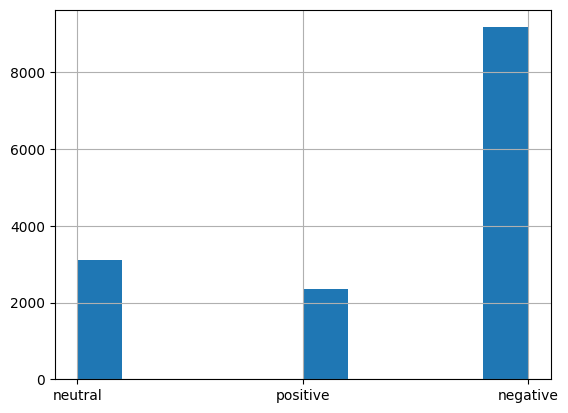

In [2]:
# Load data
data_dir = 'C:/Users/ZAKY-PC/Jupyter_proj/datasets/AirlineTweets.csv'
df= pd.read_csv(data_dir)[['airline_sentiment', 'text']].copy()


# Check distribution class
df['airline_sentiment'].hist() # immbalance dataset

Now, lets convert the label (positive, negative and neutral) into integer (1, 0, and 2) and split the dataset into test, train and validation dataset.

In [3]:
# label to integer
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)
print(df.head())

# split the dataset train, test, val
df_train, df_test = train_test_split(df, test_size= 0.30)
df_test, df_val = train_test_split(df, test_size= 0.10)

  airline_sentiment                                               text  target
0           neutral                @VirginAmerica What @dhepburn said.       2
1          positive  @VirginAmerica plus you've added commercials t...       1
2           neutral  @VirginAmerica I didn't today... Must mean I n...       2
3          negative  @VirginAmerica it's really aggressive to blast...       0
4          negative  @VirginAmerica and it's a really big bad thing...       0


Using **TfidfVectorizer**, we transform the text into vectors.TF-IDF or term frequency–inverse document frequency, are commonly used in NLP pipeline where vectorizing text documents is required. TF-IDF is the product of: 
$$
     TF - IDF = \frac{Term Frequency}{Document Frequency}\
 $$
     
     Where:
     - Term Frequency: the number of count it appears
     - Document Frequency: the number of document the word appears 

Therefore, Document frequency increase when the word apear more in more documents.

In [4]:
# convert word to vector
vectorizer = TfidfVectorizer(max_features=5000) 
x_train = vectorizer.fit_transform(df_train['text'])
x_test = vectorizer.transform(df_test['text'])
x_val = vectorizer.transform(df_val['text'])

In [5]:
# Split the dataset into train, test and val
y_train = df_train['target']
y_test = df_test['target']
y_val = df_val['target']

Now, it's time to create the model. In this repo, we use **XGBClassifier algorithm** to predict the sentiment. Firstly, let's use the default parameters for the XGBClassifier algorithm, before implementing hyper-parameter optimization to see the significant improvement.

In [6]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Now, lets **evaluate the accuracy of the prediction**. Here, I create a function to check the accuracy score of the prediction based on the mean accuracy (score),  roc and auc, and confusion matrix.

In [7]:
def accuracy_check(model, x_train, y_train, x_test, y_test):
    print("train accuracy:", np.round(model.score(x_train, y_train),2))
    print("test accuracy:", np.round(model.score(x_test, y_test),2)) 

    prob_train = model.predict_proba(x_train)
    prob_test = model.predict_proba(x_test)
    print("train AUC:", np.round(roc_auc_score(y_train, prob_train, multi_class='ovo'),2)) 
    print("test AUC:", np.round(roc_auc_score(y_test, prob_test, multi_class='ovo'),2)) 

    P_train = model.predict(x_train)
    P_test = model.predict(x_test)

    cm_train = confusion_matrix(y_train, P_train, normalize=('true'))
    cm_test = confusion_matrix(y_test, P_test, normalize=('true'))
    
    def plot_cm(cm,dataset):
        fig, ax = plt.subplots()
        classes = ['negative', 'positive', 'neutral']
        df_cm = pd.DataFrame(cm, index=classes, columns=classes)
        ax = sn.heatmap(df_cm, annot=True, fmt='g')
        ax.set_title(dataset)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Target")
        
    plot_cm(cm_train,'train')
    plot_cm(cm_test,'test')

Based on the accuracy and AUC score, we obtain very good accuracy both in train and test dataset where:

- train accuracy: 0.91
- test accuracy: 0.87
- train AUC: 0.98
- test AUC: 0.95

Lets see if we can get better score by optimizing the hyperparameters!

train accuracy: 0.91
test accuracy: 0.87
train AUC: 0.98
test AUC: 0.95


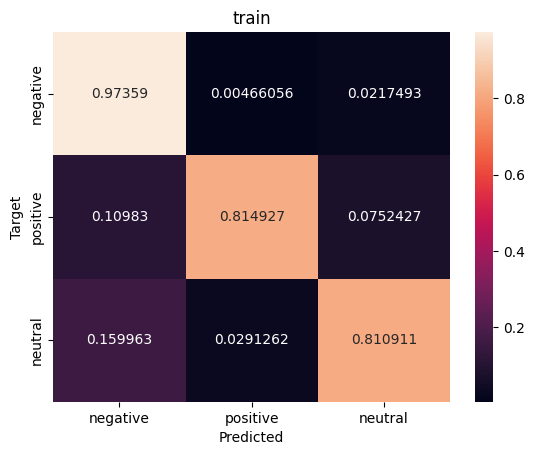

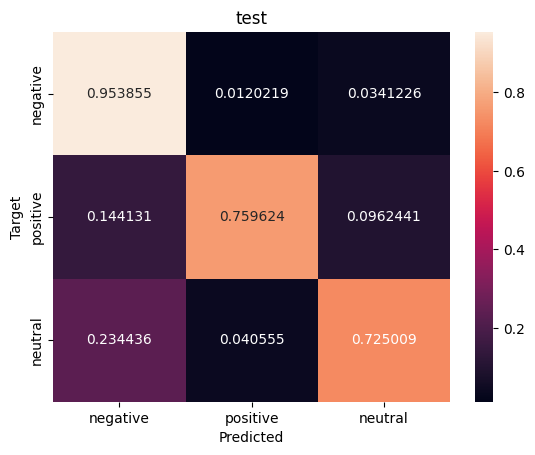

In [8]:
accuracy_check(xgb_model, x_train, y_train, x_test, y_test)

 **TPE-Bayesian hyper-parameter optimization** is used to optimize the XGBClassifier model. Using the library from [hyperopt](http://hyperopt.github.io/hyperopt/), we firstly need to specify the search space of hyperparameters. In this study, we are using 100 iteration for the maximum evaluation, softprob for the objective function, merror for the evaluation metrics and 10 iteration for early stopping. There are 7 hyper-parameters are going to be optimized:
 - n_estimator
 - learning_rate
 - gamma
 - reg_alpha
 - max_depth
 - colsample_bytree
 - min_child_weight

To learn more on how each parameters are effecting the prediction, you can read the XGBoost document [here](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters). Additionally, to learn about the parameters expression in the search space, you can read the  hyperopt wiki [here](https://github.com/hyperopt/hyperopt/wiki/FMin).

In [9]:
### parameters ###
MAX_EVALS = 30
xgb_objective = "multi:softprob" # multi:softprob, multi:softmax
xgb_eval_metrics = "merror" # "auc", "merror", mlogloss
xgb_early_stopping = 10

xgb_space = {
    'n_estimators': hp.hp.uniform('n_estimators',1000,2000),
    'learning_rate': hp.hp.choice('learning_rate',[0.005,0.05,0.5]),
    'gamma': hp.hp.uniform('gamma', 1,9),
    'reg_alpha': hp.hp.quniform('reg_alpha',0,0.5,0.1),
    'max_depth': hp.hp.choice('max_depth',np.arange(3,18,1,dtype=int)),
    'colsample_bytree' : hp.hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.hp.quniform('min_child_weight', 0, 5, 1),
}

Once we define our hyper-parameters search space, we create the **objective function**. Objective function is used to evaluate every hyperparameter (defined by the search space) based on the loss score. The highest accuracy score is used as the best model with the optimized hyperparameter configuration. In this study, accuracy_score is used to evaluate every hyper-parameters configurations. 

In [10]:
def objective(xgb_space):
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    clf = xgb.XGBClassifier( n_estimators = int(xgb_space['n_estimators']),
                            num_class = 3,
                            objective = xgb_objective,
                            learning_rate = xgb_space['learning_rate'],
                            booster = 'gblinear', 
                            gamma = xgb_space['gamma'],
                            reg_alpha = int(xgb_space['reg_alpha']),
                            max_depth = int(xgb_space['max_depth']),
                            colsample_bytree = int(xgb_space['colsample_bytree']),
                            min_child_weight = int(xgb_space['min_child_weight']),
                                  )


    clf.fit(x_train,y_train,
                    eval_set=[(x_val, y_val)],
                    eval_metric= xgb_eval_metrics,
                    early_stopping_rounds= xgb_early_stopping,
                    verbose=False
                    )
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model':clf }


Based on the objective function, here are the optimized configuration:
- 'colsample_bytree': 0.500629990613504
- 'gamma': 3.4960781295829135
- 'learning_rate': 1
- 'max_depth': 11
- 'min_child_weight': 0.0, 
- 'n_estimators': 1335.488317034181
- 'reg_alpha': 0.5

In [14]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = xgb_space,
                        algo = hp.tpe.suggest,
                        max_evals = MAX_EVALS,
                        trials = trials,
                        verbose = 0
                       )
print(best_hyperparams)

[19:56:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE: 0.7427899210686096
[19:56:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE: 0.7345931997571342
[19:56:08] WAR

[19:56:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE: 0.742562234365513
[19:56:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SCORE: 0.742562234365513
[19:56:12] WARNI

Now, lets retrain the model using the optimal configuration hyper-parameters.

In [15]:
# Train a new model with the best parameters from the search space
optimized_XGB = xgb.XGBClassifier(n_estimators = int(best_hyperparams['n_estimators']),
                               num_class = 3,
                               objective = xgb_objective, 
                               learning_rate = best_hyperparams['learning_rate'],
                               booster = 'gblinear',
                               gamma = best_hyperparams['gamma'],
                               reg_alpha = int(best_hyperparams['reg_alpha']),
                               max_depth = int(best_hyperparams['max_depth']),
                               colsample_bytree = int(best_hyperparams['colsample_bytree']),
                               min_child_weight = int(best_hyperparams['min_child_weight'])
                                )
                              
optimized_XGB.fit(x_train, y_train,
               eval_set = [(x_val, y_val)],
               eval_metric= xgb_eval_metrics,
               early_stopping_rounds= xgb_early_stopping,
               verbose=False)

[19:57:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=6.617718505331901, gpu_id=-1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=1280, n_jobs=0,
              num_class=3, num_parallel_tree=None, objective='multi:softprob',
              predictor=None, random_state=0, ...)

Comparing the accuracy between the XGBClassifier models, we can see that using the TPE-Bayesian to optimize the hyperparameters demonstrate to have better accuracy, compared to using the default huyper-parameters. This to shows that the importance of optimizing your hyperparameters for your ML models. 

train accuracy: 0.99
test accuracy: 0.91
train AUC: 1.0
test AUC: 0.94


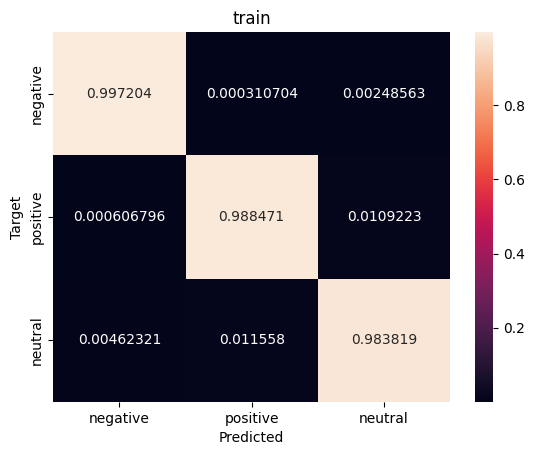

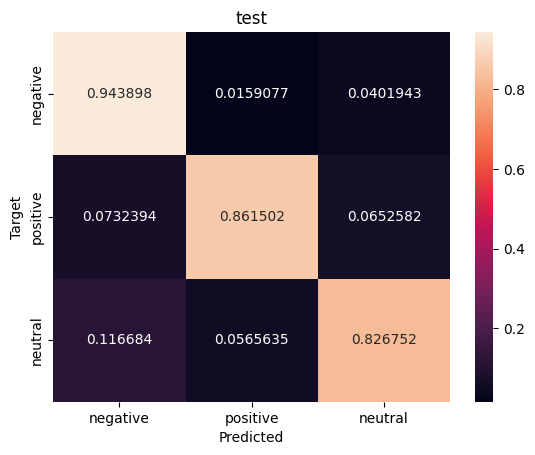

In [16]:
accuracy_check(optimized_XGB,x_train, y_train, x_test, y_test)